### 1. 预训练语义分割模型预测-视频

### 1.1 视频预测-命令行（不推荐，慢）

`python demo\video_demo.py data\street_20220330_174028.mp4 configs\mask2former\mask2former_swin-l-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024.py https://download.openmmlab.com/mmsegmentation/v0.5/mask2former/mask2former_swin-l-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024/mask2former_swin-l-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024_20221202_141901-28ad20f1.pth --device cuda:0 --output-file outputs/B3_video.mp4 `

- Output 
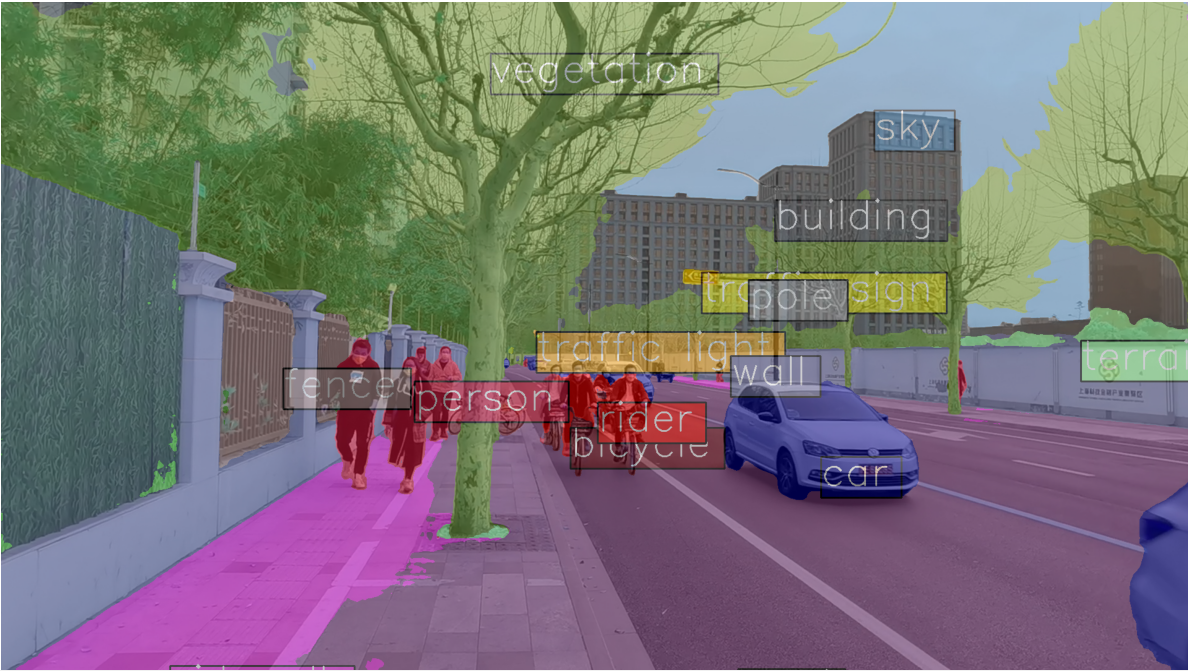

### 1.2 视频预测-Python API（推荐，快）

In [5]:
import numpy as np
import time
import shutil
import os
import torch

from PIL import Image
import cv2

import mmcv
import mmengine
from mmseg.apis import inference_model
from mmseg.utils import register_all_modules
register_all_modules()

from mmseg.datasets import CityscapesDataset


In [3]:
# 模型 config 配置文件
config_file = r'D:\Tommy\++AI\mmseg\mmsegmentation\configs\mask2former\mask2former_swin-l-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024.py'

# 模型 checkpoint 权重文件
checkpoint_file = r'D:\Tommy\++AI\mmseg\mmsegmentation\checkpoint\mask2former_swin-l-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024_20221202_141901-28ad20f1.pth'
from mmseg.apis import init_model
model = init_model(config_file, checkpoint_file, device='cuda:0')

Loads checkpoint by local backend from path: D:\Tommy\++AI\mmseg\mmsegmentation\checkpoint\mask2former_swin-l-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024_20221202_141901-28ad20f1.pth


In [6]:
from mmengine.model.utils import revert_sync_batchnorm
if not torch.cuda.is_available():
    model = revert_sync_batchnorm(model)
# input_video = 'data/traffic.mp4'

input_video = r'D:\Tommy\++AI\mmseg\mmsegmentation\data\street_20220330_174028.mp4'

temp_out_dir = time.strftime('%Y%m%d%H%M%S')
os.mkdir(temp_out_dir)
print('创建临时文件夹 {} 用于存放每帧预测结果'.format(temp_out_dir))

创建临时文件夹 20240213145139 用于存放每帧预测结果


In [7]:
# 获取 Cityscapes 街景数据集 类别名和调色板
from mmseg.datasets import cityscapes
classes = cityscapes.CityscapesDataset.METAINFO['classes']
palette = cityscapes.CityscapesDataset.METAINFO['palette']

In [8]:
def pridict_single_frame(img, opacity=0.2):
    
    result = inference_model(model, img)
    
    # 将分割图按调色板染色
    seg_map = np.array(result.pred_sem_seg.data[0].detach().cpu().numpy()).astype('uint8')
    seg_img = Image.fromarray(seg_map).convert('P')
    seg_img.putpalette(np.array(palette, dtype=np.uint8))
    
    show_img = (np.array(seg_img.convert('RGB')))*(1-opacity) + img*opacity
    
    return show_img

In [9]:
# 读入待预测视频
imgs = mmcv.VideoReader(input_video)

prog_bar = mmengine.ProgressBar(len(imgs))

# 对视频逐帧处理
for frame_id, img in enumerate(imgs):
    
    ## 处理单帧画面
    show_img = pridict_single_frame(img, opacity=0.15)
    temp_path = f'{temp_out_dir}/{frame_id:06d}.jpg' # 保存语义分割预测结果图像至临时文件夹
    cv2.imwrite(temp_path, show_img)

    prog_bar.update() # 更新进度条

# 把每一帧串成视频文件
mmcv.frames2video(temp_out_dir, r'D:\Tommy\++AI\mmseg\mmsegmentation\outputs\B3_video.mp4', fps=imgs.fps, fourcc='mp4v')

[                                                  ] 0/159, elapsed: 0s, ETA:

C:\Users\wangt\AppData\Local\anaconda3\envs\mmseg\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 138/138, 20.1 task/s, elapsed: 7s, ETA:     0ss[                                                  ] 0/138, elapsed: 0s, ETA:


In [10]:
shutil.rmtree(temp_out_dir) # 删除存放每帧画面的临时文件夹
print('删除临时文件夹', temp_out_dir)

删除临时文件夹 20240213145139


### 2. Kaggle实战-迪拜卫星航拍多类别语义分割

### 2.1 Download Dataset
- this is original image dataset, not orgnized, URL: https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery
- this is re-orgnized for ML, URL: https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/Dubai-dataset.zip

### 2.2 可视化探索数据集

In [11]:
import os

import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

#### 指定单张图像路径

Text(0.5, 1.0, 'Mask')

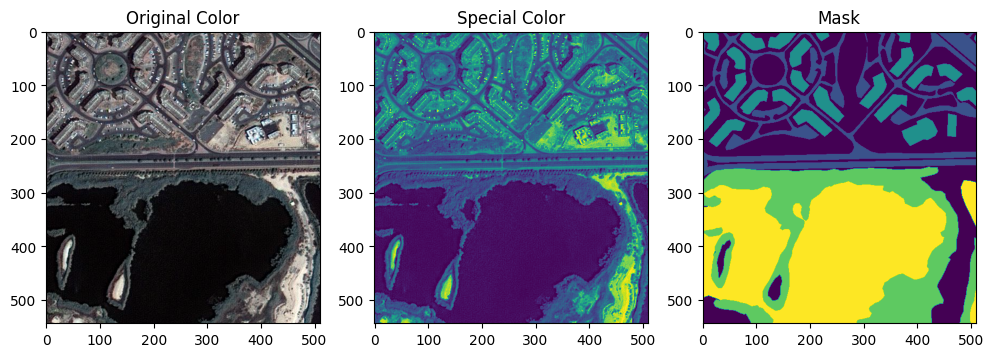

In [17]:

img_path = r'D:\Tommy\++AI\mmseg\mmsegmentation\data\Dubai-dataset\img_dir\train\14.jpg'
mask_path = r'D:\Tommy\++AI\mmseg\mmsegmentation\data\Dubai-dataset\ann_dir\train\14.png'
img = cv2.imread(img_path)
mask = cv2.imread(mask_path)

# create figure 
fig = plt.figure(figsize=(12, 7)) 
# Adds a subplot at the 1st position 
rows = 1
columns = 3
fig.add_subplot(rows, columns, 1) 
plt.imshow(img)
plt.title("Original Color") 
fig.add_subplot(rows, columns, 2) 
plt.imshow(img[:,:,0])
plt.title("Special Color") 
fig.add_subplot(rows, columns, 3) 
plt.imshow(mask[:,:,0])
plt.title("Mask") 

#### 高亮区域透明度，越小越接近原图

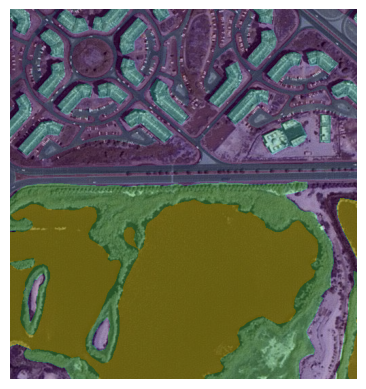

In [18]:

plt.imshow(img[:,:,::-1])
plt.imshow(mask[:,:,0], alpha=0.4) # alpha 高亮区域透明度，越小越接近原图
plt.axis('off')
plt.show()

### 2.3 批量可视化图像和标注

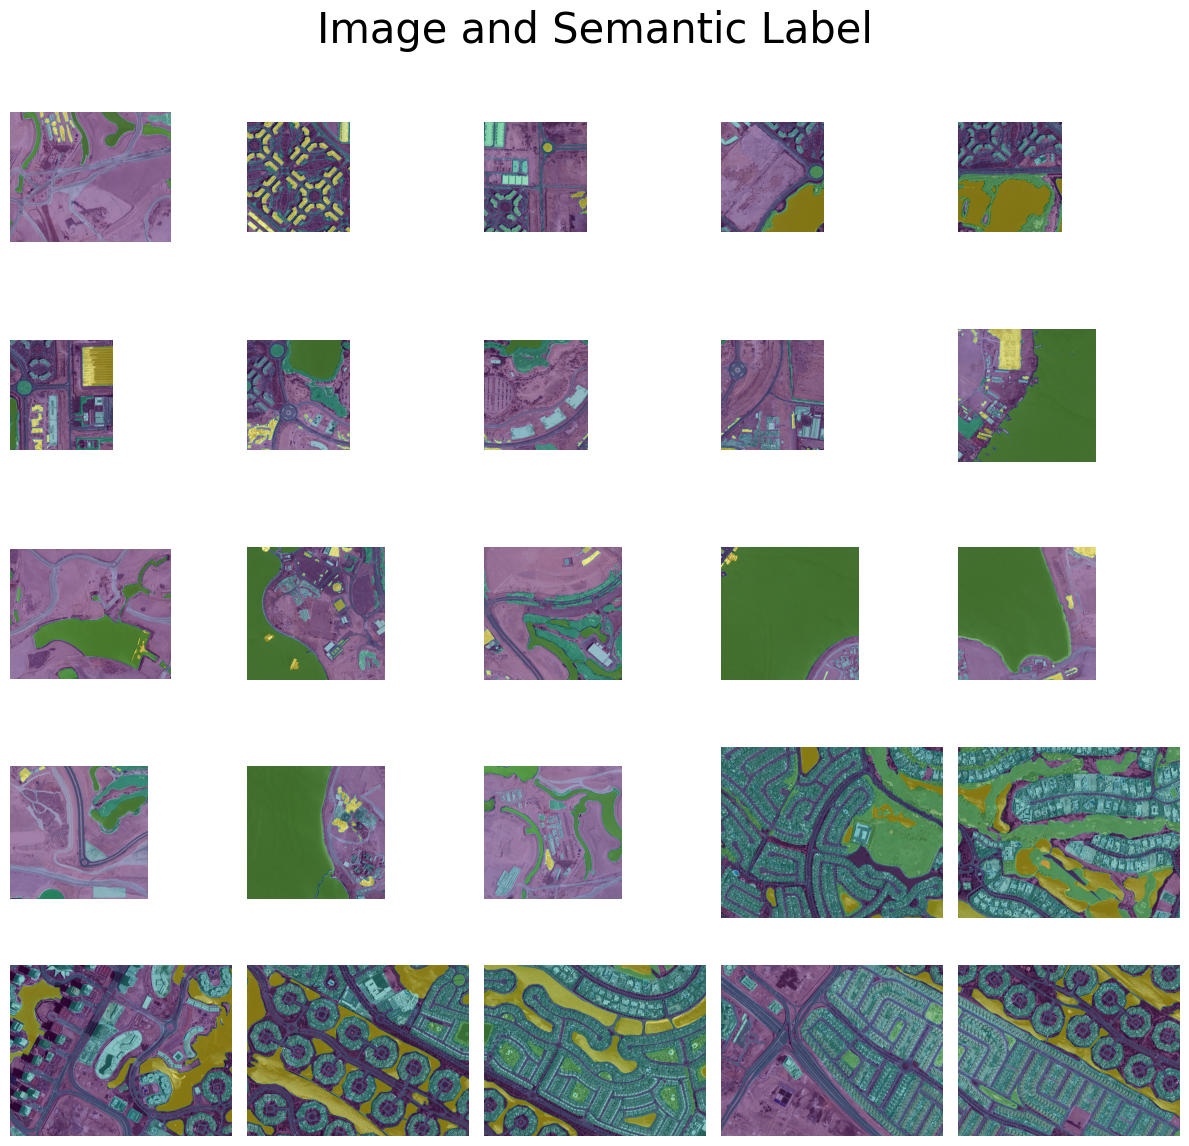

In [20]:
# 指定图像和标注路径
PATH_IMAGE = r'D:\Tommy\++AI\mmseg\mmsegmentation\data\Dubai-dataset/img_dir/train'
PATH_MASKS = r'D:\Tommy\++AI\mmseg\mmsegmentation\data\Dubai-dataset/ann_dir/train'

# n行n列可视化
n = 5

# 标注区域透明度
opacity = 0.5

fig, axes = plt.subplots(nrows=n, ncols=n, sharex=True, figsize=(12,12))

for i, file_name in enumerate(os.listdir(PATH_IMAGE)[:n**2]):
    
    # 载入图像和标注
    img_path = os.path.join(PATH_IMAGE, file_name)
    mask_path = os.path.join(PATH_MASKS, file_name.split('.')[0]+'.png')
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    
    # 可视化
    axes[i//n, i%n].imshow(img)
    axes[i//n, i%n].imshow(mask[:,:,0], alpha=opacity)
    axes[i//n, i%n].axis('off') # 关闭坐标轴显示
fig.suptitle('Image and Semantic Label', fontsize=30)
plt.tight_layout()
plt.show()